In [2]:
import torch
import os
import pandas as pd
import numpy as np
import jieba
from tensorflow import keras
from keras.datasets import imdb
from sklearn.metrics import roc_curve, auc
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, OrderedDict
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from scipy import io
import time
import torchtext
from torch.nn.utils.rnn import pad_sequence
import torch
from torchtext.vocab import build_vocab_from_iterator, Vocab
from torch.nn.utils.rnn import pad_sequence
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.metrics import roc_curve, auc
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import os
from collections import Counter, OrderedDict
import torch
from torch import nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence, pad_sequence
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_curve, auc, confusion_matrix
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
from jieba import lcut
from torchtext.vocab import vocab
from torchtext.transforms import VocabTransform
import scipy.io as io
import numpy as np

In [7]:
# 数据处理
def getFormatData():
    # 加载 Keras IMDb 数据集
    (x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=10000)
    #print(x_train)
    
    # 数据预处理：填充序列使其具有相同的长度
    max_len = 100  # 限定评论的最大长度
    x_train = pad_sequence([torch.tensor(seq) for seq in x_train], batch_first=True, padding_value=0)
    #print(x_train)
    x_test = pad_sequence([torch.tensor(seq) for seq in x_test], batch_first=True, padding_value=0)

    # Truncate or pad sequences to the specified max_len
    x_train = x_train[:, :max_len]
    x_test = x_test[:, :max_len]

    # 将 NumPy 数组转换为 PyTorch Tensor
    y_train = torch.tensor(y_train)
    y_test = torch.tensor(y_test)

    # 创建父目录
    os.makedirs('./dataset/data', exist_ok=True)
    
    # 保存数据
    data = {'X_train': x_train, 'y_train': y_train, 'X_test': x_test, 'y_test': y_test}
    torch.save(data, './dataset/data/data.pt')

# 数据集加载
class CustomDataset(Dataset):
    def __init__(self, mode='train'):
        data = torch.load('./dataset/data/data.pt')
        if mode == 'train':
            self.X = data['X_train']
            self.y = data['y_train']
        elif mode == 'test':
            self.X = data['X_test']
            self.y = data['y_test']

    def __getitem__(self, item):
        return self.X[item], self.y[item], torch.tensor(len(self.X[item]))  # Add lengths here

    def __len__(self):
        return len(self.X)

# 数据加载器
class CustomDataLoader:
    def __init__(self, batch_size):
        train_data = CustomDataset('train')
        test_data = CustomDataset('test')
       # print(f"Number of training samples: {len(train_data)}")
       # print(f"Number of test samples: {len(test_data)}")
        self.traindl = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=0)
        self.testdl = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=0)


# 定义网络结构
class GRU(nn.Module):
    def __init__(self, num_words, num_classes, input_size=64, hidden_dim=32, num_layers=2):
        super(GRU, self).__init__()
        self.embedding = nn.Embedding(num_words, input_size)
        self.gru = nn.GRU(input_size, hidden_dim, num_layers, batch_first=True, bidirectional=True)
        self.classification = nn.Sequential(
            nn.Linear(hidden_dim * 2, 32),
            nn.ReLU(inplace=True),
            nn.Linear(32, num_classes)
        )

    def forward(self, x, lengths):
        x = self.embedding(x)
        packed_x = pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)
        packed_output, hn = self.gru(packed_x)
        output, _ = pad_packed_sequence(packed_output, batch_first=True)
        pred = self.classification(output[:, -1, :])  # 取最后一个时间步的输出
        return pred

# 定义训练过程
class CustomTrainer:
    def __init__(self):
        self._safe_create_dir()
        self.device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
        self._init_data()
        self._init_model()

    def _safe_create_dir(self):
        # Create 'results/' directory if it doesn't exist
        os.makedirs('results/', exist_ok=True)

    def _init_data(self):
        # Replace 'batch_size' with your desired batch size
        data_loader = CustomDataLoader(batch_size=32)
        self.traindl = data_loader.traindl
        self.testdl = data_loader.testdl

    def _init_model(self):
        # Replace CustomModel with your actual model implementation
        self.model = GRU(num_words=10000, num_classes=2)  # Replace with your actual num_words and num_classes
       # print(self.model)
       # print("Number of model parameters:", sum(p.numel() for p in self.model.parameters() if p.requires_grad))
        self.cri = torch.nn.CrossEntropyLoss()
        self.opt = torch.optim.Adam(self.model.parameters(), lr=0.001)  # Use self.model.parameters()

    def save_model(self):
        save_dir = 'saved_dict'
        os.makedirs(save_dir, exist_ok=True)
        save_path = os.path.join(save_dir, 'gru.pt')
        torch.save(self.model.state_dict(), save_path)

    def load_model(self):
        self.model.load_state_dict(torch.load('saved_dict/gru.pt'))

    def train(self, epochs):
        patten = 'Epoch: %d   [===========]  cost: %.2fs;  loss: %.4f;  train acc: %.4f;  val acc:%.4f;'
        train_accs = []
        c_loss = []
        print("Start of the loop")
        for epoch in range(epochs):
            print("Start of epoch %d" % epoch)
            cur_preds = torch.empty(0).to(self.device)
            cur_labels = torch.empty(0).to(self.device)
            cur_loss = 0
            start = time.time()
            self.model.train()
            for batch, (inputs, targets, lengths) in enumerate(self.traindl):
                print(len(self.traindl.dataset))
               # print(f"Batch {batch}: Inputs shape: {inputs.shape}, Targets shape: {targets.shape}, Lengths: {lengths}")
                inputs = inputs.to(self.device)
                targets = targets.to(self.device)
                lengths = lengths.to('cpu')
                pred = self.model(inputs, lengths)
                loss = self.cri(pred, targets)
                self.opt.zero_grad()
                loss.backward()
                self.opt.step()
                cur_preds = torch.cat([cur_preds, pred.argmax(dim=1)])
                cur_labels = torch.cat([cur_labels, targets])
                cur_loss += loss.item()
            acc = accuracy_score(cur_labels, cur_preds)
            val_acc, _, _, _ = self.val()
            train_accs.append(acc)
            c_loss.append(cur_loss)
            end = time.time()
            print("End of epoch %d" % epoch)
            print(patten % (epoch, end - start, cur_loss, acc, val_acc))
          #  sys.stdout.flush()  # 强制刷新输出

        self.save_model()
        plot_acc(train_accs)
        plot_loss(c_loss)

    @torch.no_grad()
    def val(self):
        self.model.eval()
        cur_preds = torch.empty(0).to(self.device)
        cur_labels = torch.empty(0).to(self.device)
        for batch, (inputs, targets, lengths) in enumerate(self.testdl):  # You might need to replace self.testdl with self.valdl
            inputs = inputs.to(self.device)
            targets = targets.to(self.device)
            lengths = lengths.to('cpu')
            pred = self.model(inputs, lengths)
            cur_preds = torch.cat([cur_preds, pred.argmax(dim=1)])
            cur_labels = torch.cat([cur_labels, targets])
        acc = accuracy_score(cur_labels, cur_preds)

        # Compute precision, recall, and F1 score
        precision, recall, f1, _ = precision_recall_fscore_support(cur_labels, cur_preds, average='binary')

        self.model.train()
        return acc, precision, recall, f1

    @torch.no_grad()
    def test(self):
        print("test ...")
        self.load_model()
        self.model.eval()

        cur_preds = torch.empty(0).to(self.device)
        cur_labels = torch.empty(0).to(self.device)

        for batch, (inputs, targets, lengths) in enumerate(self.testdl):
            inputs = inputs.to(self.device)
            targets = targets.to(self.device)
            lengths = lengths.to('cpu')
            pred = self.model(inputs, lengths)
            cur_preds = torch.cat([cur_preds, pred.argmax(dim=1)])
            cur_labels = torch.cat([cur_labels, targets])

        val_acc, precision, recall, f1 = self.val()

        print(f'Test Accuracy: {val_acc}')
        print(f'Precision: {precision}')
        print(f'Recall: {recall}')
        print(f'F1 Score: {f1}')

        # Calculate AUC-ROC
        cur_labels = np.asarray(cur_labels).ravel()  # 将标签展平成一维数组
        cur_preds = np.asarray(cur_preds).ravel()  # 将预测概率展平成一维数组

        fpr, tpr, thresholds = roc_curve(cur_labels, cur_preds)
        auc = auc(fpr, tpr)

        # Plot AUC-ROC curve
        plt.plot(fpr, tpr, label='ROC curve (area = %.2f)' % auc)
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC)')
        plt.legend(loc="lower right")
        plt.savefig('ROC_curve.png', dpi=300)
        plt.show()

        # Confusion matrix
        cv_conf = confusion_matrix(cur_labels.cpu(), cur_preds.cpu())
        labels11 = ['negative', 'active']
        disp = ConfusionMatrixDisplay(confusion_matrix=cv_conf, display_labels=labels11)
        disp.plot(cmap="Blues", values_format='')
        plt.savefig("results/ConfusionMatrix.png", dpi=400)

        self.model.train()

def plot_acc(train_acc):
    sns.set(style='darkgrid')
    plt.figure(figsize=(10, 7))
    x = list(range(len(train_acc)))
    plt.plot(x, train_acc, alpha=0.9, linewidth=2, label='train acc')
    plt.xlabel('Epoch')
    plt.ylabel('Acc')
    plt.legend(loc='best')
    plt.savefig('results/acc.png', dpi=400)


def plot_loss(train_loss):
    sns.set(style='darkgrid')
    plt.figure(figsize=(10, 7))
    x = list(range(len(train_loss)))
    plt.plot(x, train_loss, alpha=0.9, linewidth=2, label='train loss')
    plt.xlabel('Epoch')
    plt.ylabel('loss')
    plt.legend(loc='best')
    plt.savefig('results/loss.png', dpi=400)

In [29]:
# 数据处理
def getFormatData():
    # 加载 Keras IMDb 数据集
    (x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=10000)
    #print(x_train)
    
    # 数据预处理：填充序列使其具有相同的长度
    max_len = 100  # 限定评论的最大长度
    x_train = pad_sequence([torch.tensor(seq) for seq in x_train], batch_first=True, padding_value=0)
    #print(x_train)
    x_test = pad_sequence([torch.tensor(seq) for seq in x_test], batch_first=True, padding_value=0)

    # Truncate or pad sequences to the specified max_len
    x_train = x_train[:, :max_len]
    x_test = x_test[:, :max_len]

    # 将 NumPy 数组转换为 PyTorch Tensor
    y_train = torch.tensor(y_train)
    y_test = torch.tensor(y_test)

    # 创建父目录
    os.makedirs('./dataset/data', exist_ok=True)
    
    # 保存数据
    data = {'X_train': x_train, 'y_train': y_train, 'X_test': x_test, 'y_test': y_test}
    torch.save(data, './dataset/data/data.pt')

# 数据集加载
class CustomDataset(Dataset):
    def __init__(self, mode='train'):
        data = torch.load('./dataset/data/data.pt')
        if mode == 'train':
            self.X = data['X_train']
            self.y = data['y_train']
        elif mode == 'test':
            self.X = data['X_test']
            self.y = data['y_test']

    def __getitem__(self, item):
        return self.X[item], self.y[item], torch.tensor(len(self.X[item]))  # Add lengths here

    def __len__(self):
        return len(self.X)

# 数据加载器
class CustomDataLoader:
    def __init__(self, batch_size):
        train_data = CustomDataset('train')
        test_data = CustomDataset('test')
       # print(f"Number of training samples: {len(train_data)}")
       # print(f"Number of test samples: {len(test_data)}")
        self.traindl = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=0)
        self.testdl = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=0)


# 定义网络结构
class GRU(nn.Module):
    def __init__(self, num_words, num_classes, input_size=64, hidden_dim=32, num_layers=2):
        super(GRU, self).__init__()
        self.embedding = nn.Embedding(num_words, input_size)
        self.gru = nn.GRU(input_size, hidden_dim, num_layers, batch_first=True, bidirectional=True)
        self.classification = nn.Sequential(
            nn.Linear(hidden_dim * 2, 32),
            nn.ReLU(inplace=True),
            nn.Linear(32, num_classes)
        )

    def forward(self, x, lengths):
        x = self.embedding(x)
        packed_x = pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)
        packed_output, hn = self.gru(packed_x)
        output, _ = pad_packed_sequence(packed_output, batch_first=True)
        pred = self.classification(output[:, -1, :])  # 取最后一个时间步的输出
        return pred

# 定义训练过程
class CustomTrainer:
    def __init__(self):
        self._safe_create_dir()
        self.device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
        self._init_data()
        self._init_model()

    def _safe_create_dir(self):
        # Create 'results/' directory if it doesn't exist
        os.makedirs('results/', exist_ok=True)

    def _init_data(self):
        # Replace 'batch_size' with your desired batch size
        data_loader = CustomDataLoader(batch_size=32)
        self.traindl = data_loader.traindl
        self.testdl = data_loader.testdl

    def _init_model(self):
        # Replace CustomModel with your actual model implementation
        self.model = GRU(num_words=10000, num_classes=2)  # Replace with your actual num_words and num_classes
       # print(self.model)
       # print("Number of model parameters:", sum(p.numel() for p in self.model.parameters() if p.requires_grad))
        self.cri = torch.nn.CrossEntropyLoss()
        self.opt = torch.optim.Adam(self.model.parameters(), lr=0.001)  # Use self.model.parameters()

    def save_model(self):
        save_dir = 'saved_dict'
        os.makedirs(save_dir, exist_ok=True)
        save_path = os.path.join(save_dir, 'gru.pt')
        torch.save(self.model.state_dict(), save_path)

    def load_model(self):
        self.model.load_state_dict(torch.load('saved_dict/gru.pt'))

    def train(self,epochs):
        patten = 'Epoch: %d   [===========]  cost: %.2fs;  loss: %.4f;  train acc: %.4f;  val acc:%.4f;'
        train_accs = []
        c_loss = []
        for epoch in range(epochs):
            print("Start of the loop")
            cur_preds = np.empty(0)
            cur_labels = np.empty(0)
            cur_loss = 0
            start = time.time()
            # Initialize variables
            train_lossi = 0.0
            train_acci = 0.0

            # Inside your training loop
            for batch, (inputs, targets, lengths) in enumerate(self.traindl):
                #print(len(self.traindl.dataset))
                inputs = inputs.to(self.device)
                targets = targets.to(self.device)
                lengths = lengths.to('cpu')

                pred = self.model(inputs, lengths)
                loss = F.cross_entropy(pred, targets)  # Use CrossEntropyLoss

                self.opt.zero_grad()
                loss.backward()
                self.opt.step()

                # Calculate loss, accuracy, and other metrics
                true = targets.data.cpu()
                predic = torch.max(pred.data, 1)[1].cpu()
                train_lossi += loss.item()
                train_acci += metrics.accuracy_score(true, predic)

                cur_preds = np.concatenate([cur_preds, predic.numpy()])
                cur_labels = np.concatenate([cur_labels, true.numpy()])
                cur_loss += loss.item()

            acc = train_acci / (batch + 1)
            train_loss = train_lossi / (batch + 1)
            val_acc, _, _, _ = self.val()
            train_accs.append(acc)
            c_loss.append(train_loss)
            end = time.time()
            print("End of epoch %d" % epoch)
            print(patten % (epoch, end - start, train_loss, acc, val_acc))

        self.save_model()
        plot_acc(train_accs)
        plot_loss(c_loss)

    # @torch.no_grad()中的数据不需要计算梯度，也不会进行反向传播
    @torch.no_grad()
    def val(self):
        self.model.eval()
        cur_preds = np.empty(0)
        cur_labels = np.empty(0)
        for batch, (inputs, targets, lengths) in enumerate(self.testdl):
            inputs = inputs.to(self.device)
            targets = targets.to(self.device)
            lengths = lengths.to('cpu')
            pred = self.model(inputs, lengths)
            cur_preds = np.concatenate([cur_preds, pred.cpu().detach().numpy().argmax(axis=1)])
            cur_labels = np.concatenate([cur_labels, targets.cpu().numpy()])
        #acc, precision, f1, recall = metrics(cur_preds, cur_labels)
        acc = accuracy_score(cur_labels, cur_preds)
        precision, recall, f1, _ = precision_recall_fscore_support(cur_labels, cur_preds, average='binary')
        
        self.model.train()
        return acc, precision, f1, recall
    
    @torch.no_grad()
    def test(self):
        print("test ...")
        self.load_model()
        patten = 'test acc: %.4f   precision: %.4f   recall: %.4f    f1: %.4f    '
        self.net.eval()
        cur_preds = np.empty(0)
        cur_labels = np.empty(0)
        for batch, (inputs, targets, lengths) in enumerate(self.testdl):
            inputs = inputs.to(self.device)
            targets = targets.to(self.device)
            lengths = lengths.to('cpu')
            pred = self.model(inputs, lengths)
            cur_preds = np.concatenate([cur_preds, pred.cpu().detach().numpy().argmax(axis=1)])
            cur_labels = np.concatenate([cur_labels, targets.cpu().numpy()])

        val_acc, precision, recall, f1 = self.val()

        print(f'Test Accuracy: {val_acc}')
        print(f'Precision: {precision}')
        print(f'Recall: {recall}')
        print(f'F1 Score: {f1}')

        # Calculate AUC-ROC
        fpr, tpr, thresholds = roc_curve(cur_labels, cur_preds)
        roc_auc = auc(fpr, tpr)

        # Plot AUC-ROC curve
        plt.figure()
        lw = 2
        plt.plot(fpr, tpr, color='darkorange', lw=lw, label=f'AUC = {roc_auc:.2f}')
        plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic Curve')
        plt.legend(loc="lower right")
        plt.savefig("results/AUC_ROC_Curve.png", dpi=400)

        # Confusion matrix
        cv_conf = confusion_matrix(cur_labels, cur_preds)
        labels11 = ['negative', 'active']
        disp = ConfusionMatrixDisplay(confusion_matrix=cv_conf, display_labels=labels11)
        disp.plot(cmap="Blues", values_format='')
        plt.savefig("results/ConfusionMatrix.png", dpi=400)

        self.model.train()

def plot_acc(train_acc):
    sns.set(style='darkgrid')
    plt.figure(figsize=(10, 7))
    x = list(range(len(train_acc)))
    plt.plot(x, train_acc, alpha=0.9, linewidth=2, label='train acc')
    plt.xlabel('Epoch')
    plt.ylabel('Acc')
    plt.legend(loc='best')
    plt.savefig('results/acc.png', dpi=400)


def plot_loss(train_loss):
    sns.set(style='darkgrid')
    plt.figure(figsize=(10, 7))
    x = list(range(len(train_loss)))
    plt.plot(x, train_loss, alpha=0.9, linewidth=2, label='train loss')
    plt.xlabel('Epoch')
    plt.ylabel('loss')
    plt.legend(loc='best')
    plt.savefig('results/loss.png', dpi=400)

Start of the loop
End of epoch 0
Epoch: 0   [===========]  cost: 166.18s;  loss: 0.6829;  train acc: 0.5496;  val acc:0.6845;
Start of the loop
End of epoch 1
Epoch: 1   [===========]  cost: 163.61s;  loss: 0.4760;  train acc: 0.7726;  val acc:0.7906;
Start of the loop
End of epoch 2
Epoch: 2   [===========]  cost: 155.65s;  loss: 0.3415;  train acc: 0.8529;  val acc:0.8001;
Start of the loop
End of epoch 3
Epoch: 3   [===========]  cost: 155.36s;  loss: 0.2672;  train acc: 0.8921;  val acc:0.8181;
Start of the loop
End of epoch 4
Epoch: 4   [===========]  cost: 160.00s;  loss: 0.2020;  train acc: 0.9213;  val acc:0.8150;
Start of the loop
End of epoch 5
Epoch: 5   [===========]  cost: 156.07s;  loss: 0.1424;  train acc: 0.9494;  val acc:0.8036;
Start of the loop
End of epoch 6
Epoch: 6   [===========]  cost: 156.40s;  loss: 0.0898;  train acc: 0.9717;  val acc:0.8053;
Start of the loop
End of epoch 7
Epoch: 7   [===========]  cost: 157.75s;  loss: 0.0603;  train acc: 0.9806;  val acc:

AttributeError: 'CustomTrainer' object has no attribute 'net'

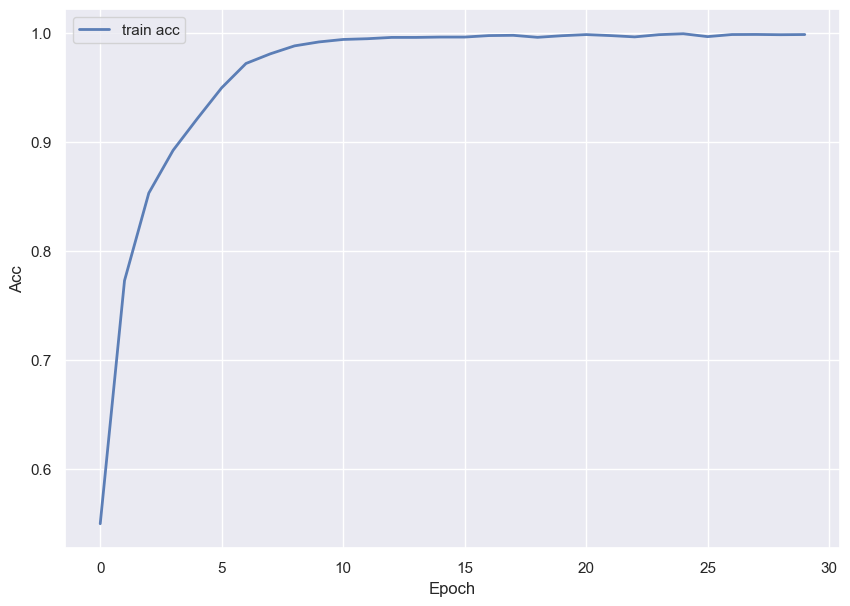

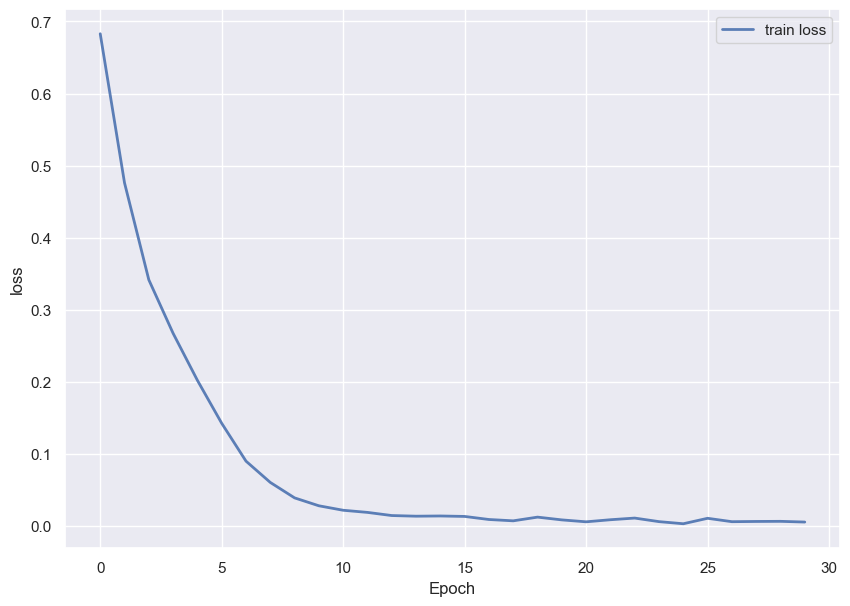

In [30]:
if __name__ == "__main__":
    getFormatData()
    trainer = CustomTrainer()
    trainer.train(epochs=30)
    trainer.test()

Start of the loop
Start of epoch 0
End of epoch 0
Epoch: 0   [===========]  cost: 171.56s;  loss: 523.2653;  train acc: 0.5667;  val acc:0.7184;
Start of epoch 1
End of epoch 1
Epoch: 1   [===========]  cost: 166.64s;  loss: 354.8335;  train acc: 0.7857;  val acc:0.8011;
Start of epoch 2
End of epoch 2
Epoch: 2   [===========]  cost: 168.80s;  loss: 264.3265;  train acc: 0.8542;  val acc:0.8179;
Start of epoch 3
End of epoch 3
Epoch: 3   [===========]  cost: 166.68s;  loss: 208.4947;  train acc: 0.8901;  val acc:0.8164;
Start of epoch 4
End of epoch 4
Epoch: 4   [===========]  cost: 164.92s;  loss: 159.3628;  train acc: 0.9212;  val acc:0.8127;
Start of epoch 5
End of epoch 5
Epoch: 5   [===========]  cost: 171.42s;  loss: 111.7541;  train acc: 0.9480;  val acc:0.7998;
Start of epoch 6
End of epoch 6
Epoch: 6   [===========]  cost: 171.27s;  loss: 76.5279;  train acc: 0.9654;  val acc:0.7990;
Start of epoch 7
End of epoch 7
Epoch: 7   [===========]  cost: 172.52s;  loss: 51.0032;  trai

AttributeError: 'numpy.ndarray' object has no attribute 'cpu'

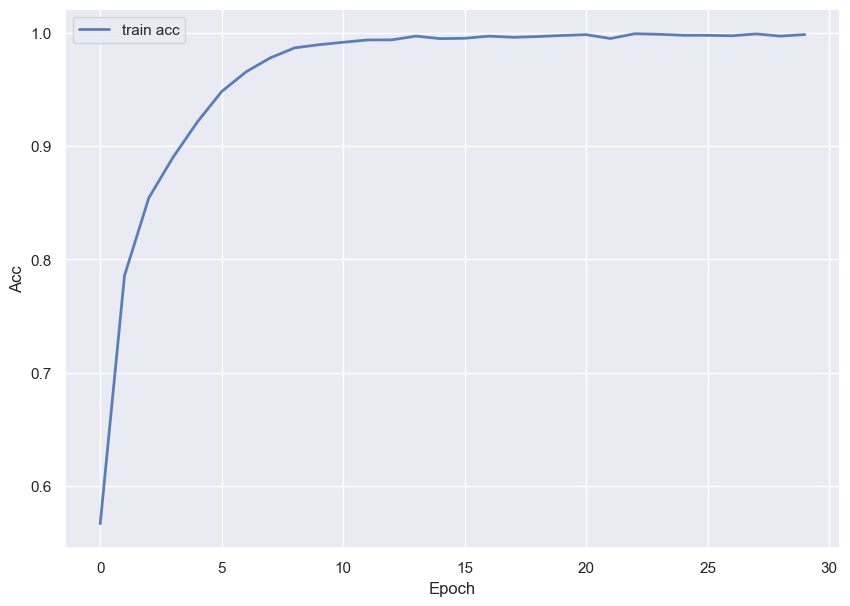

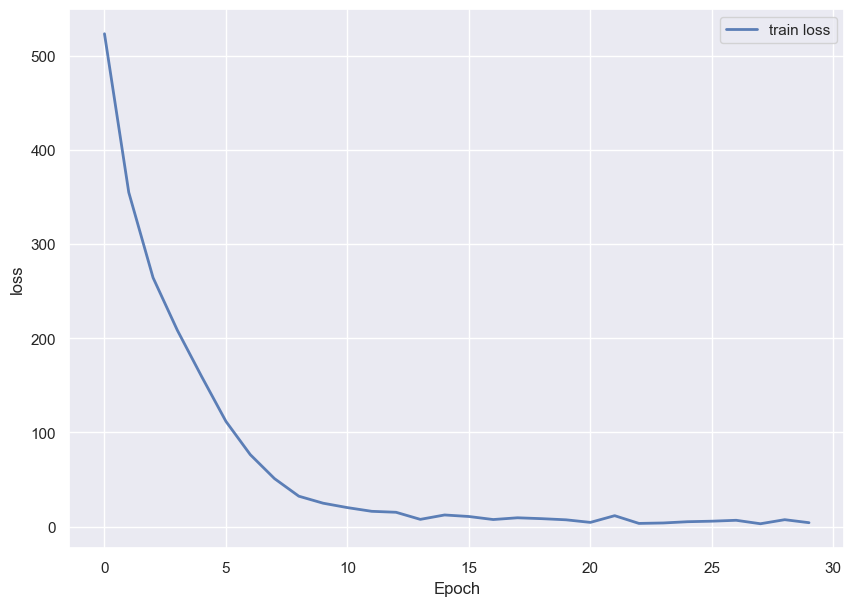

In [5]:
if __name__ == "__main__":
    getFormatData()
    trainer = CustomTrainer()
    trainer.train(epochs=30)
    trainer.test()

In [11]:
trainer.test()

test ...
Test Accuracy: 0.78192
Precision: 0.8420695010677538
Recall: 0.694
F1 Score: 0.7608981668274712


AttributeError: 'numpy.ndarray' object has no attribute 'cpu'

test ...
Test Accuracy: 0.80352
Precision: 0.8392346208869814
Recall: 0.75088
F1 Score: 0.7926026009120082


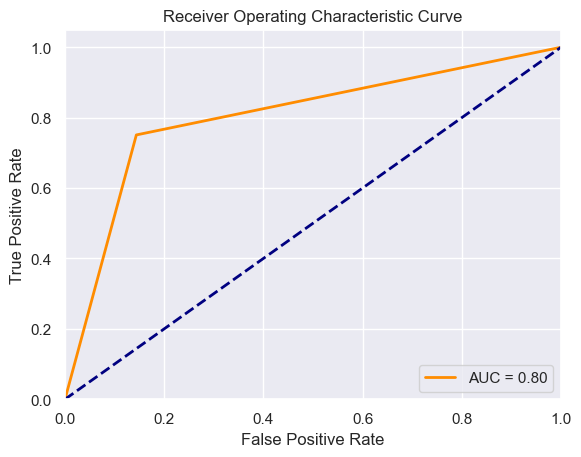

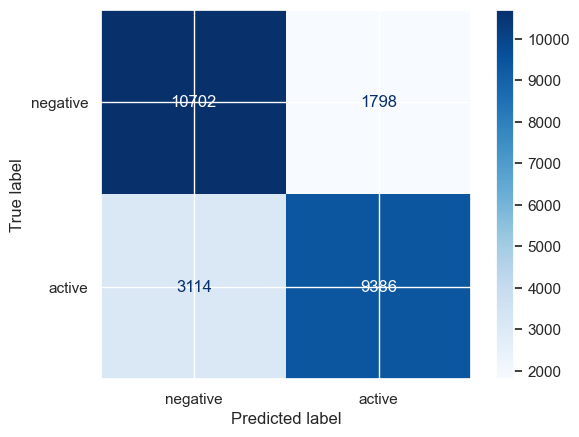

In [30]:
from sklearn.metrics import roc_curve, auc
trainer.test()

Start of the loop
Start of epoch 0
End of epoch 0
Epoch: 0   [===========]  cost: 151.67s;  loss: 536.5910;  train acc: 0.5411;  val acc:0.5459;
Start of epoch 1
End of epoch 1
Epoch: 1   [===========]  cost: 156.02s;  loss: 420.9793;  train acc: 0.7224;  val acc:0.7854;
Start of epoch 2
End of epoch 2
Epoch: 2   [===========]  cost: 152.80s;  loss: 291.6768;  train acc: 0.8356;  val acc:0.8093;
Start of epoch 3
End of epoch 3
Epoch: 3   [===========]  cost: 153.00s;  loss: 228.8603;  train acc: 0.8801;  val acc:0.8138;
Start of epoch 4
End of epoch 4
Epoch: 4   [===========]  cost: 152.91s;  loss: 177.2304;  train acc: 0.9121;  val acc:0.7984;
Start of epoch 5
End of epoch 5
Epoch: 5   [===========]  cost: 152.45s;  loss: 130.9738;  train acc: 0.9398;  val acc:0.7992;
Start of epoch 6
End of epoch 6
Epoch: 6   [===========]  cost: 152.12s;  loss: 88.5765;  train acc: 0.9625;  val acc:0.7989;
Start of epoch 7
End of epoch 7
Epoch: 7   [===========]  cost: 154.98s;  loss: 59.7669;  trai

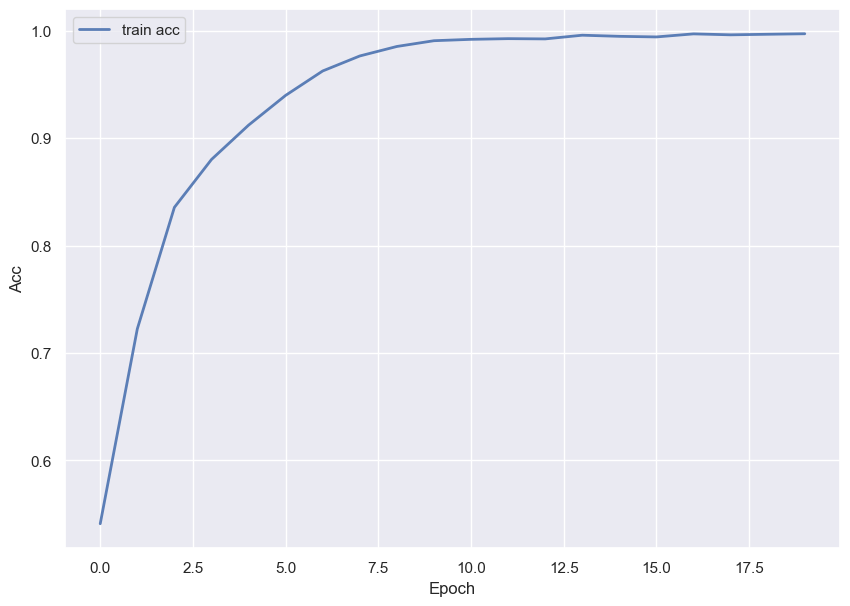

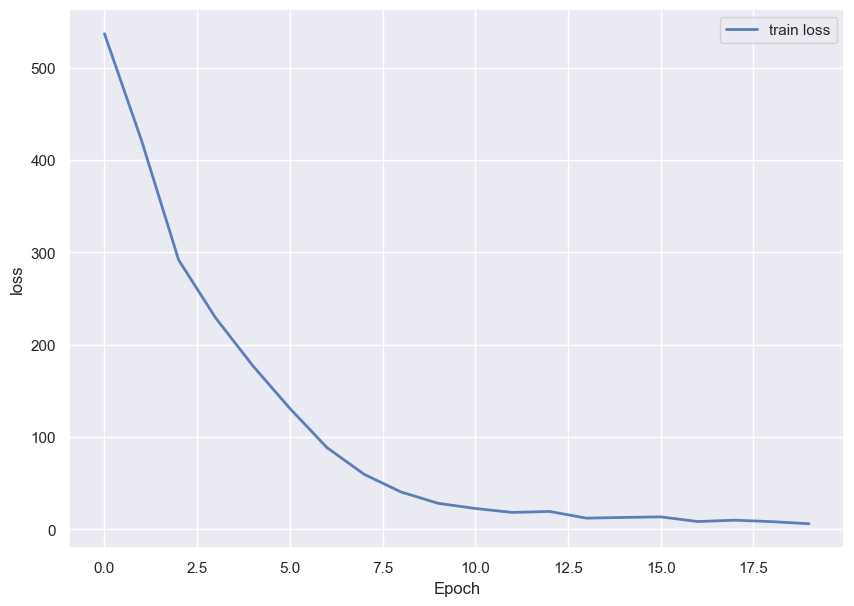

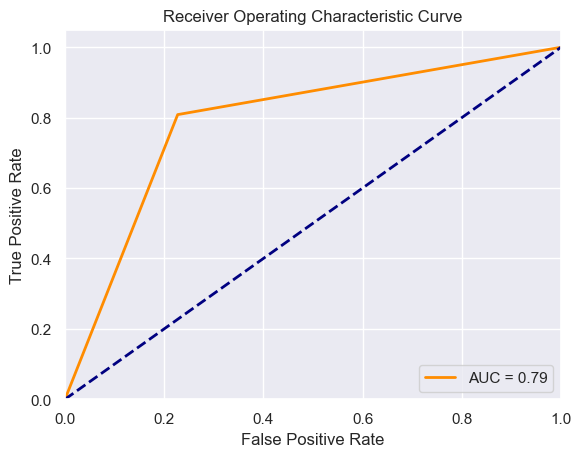

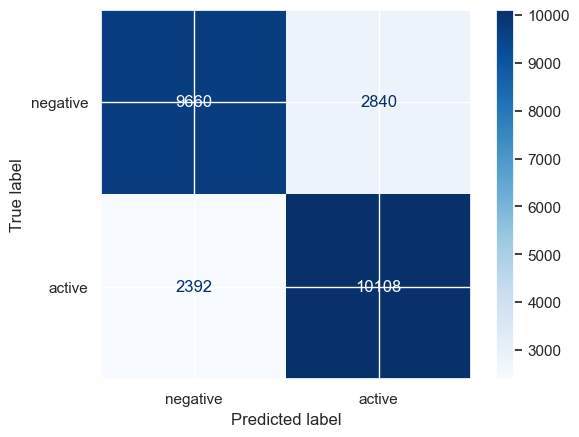

In [31]:
if __name__ == "__main__":
    getFormatData()
    trainer = CustomTrainer()
    trainer.train(epochs = 20)
    trainer.test()

In [15]:
# -*- coding: utf-8 -*-
from jieba import lcut
import os
from torchtext.vocab import vocab
from collections import OrderedDict, Counter
from torchtext.transforms import VocabTransform
from torch.nn.utils.rnn import pack_padded_sequence, pad_sequence
from sklearn.preprocessing import LabelEncoder
import scipy.io as io
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch
from torch.optim import Adam
import numpy as np
#from utils import metrics, cost, safeCreateDir
import time
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import torch.nn.functional as F
from sklearn import metrics  # Add this import statement

def safeCreateDir(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)
        
# 数据处理
# """判断一个unicode是否是汉字"""
def is_chinese(uchar):
    if (uchar >= '\u4e00' and uchar <= '\u9fa5') :
        return True
    else:
        return False
# 是中文就留下 不是就跳过
def reserve_chinese(content):
    content_str = ''
    for i in content:
        if is_chinese(i):
            content_str += i
    return content_str
# 读取去停用词库
def getStopWords():
    file = open('./dataset/stopwords.txt', 'r',encoding='utf8')
    words = [i.strip() for i in file.readlines()]
    file.close()
    return words
# 数据清洗、分词、去停用词
def dataParse(text, stop_words):
    fields = text.split(',')

    # Check if the line has enough fields
    if len(fields) < 9:
        return None
    # Ensure that the field containing star information is a valid integer
    try:
        star = int(fields[7])
    except ValueError:
        return None

    # Filter out instances with stars other than 1 or 5
    if star != 1 and star != 5:
        return None

    # Convert star labels as specified
    label = 0 if star == 1 else 1
    comment = reserve_chinese(fields[8])
    
    # Process the comment or other relevant fields as needed
    
    # Tokenize and remove stop words
    words = lcut(comment)
    words = [i for i in words if not i in stop_words]
    
    return words, label

def getFormatData():
    file_path = './DMSC.csv'  # Update the path to your DMSC dataset
    num_lines_to_read = 149800
    
    with open(file_path, 'r', encoding='utf-8') as file:
        texts = [next(file) for _ in range(num_lines_to_read)]

    stop_words = getStopWords()
    all_words = []
    all_labels = []

    for text in texts:
        result = dataParse(text, stop_words)
        if result is not None:
            content, label = result
            if len(content) <= 0:
                continue
            all_words.append(content)
            all_labels.append(label)

    # 自制词表Vocab
    # 将所有词都汇总到一个列表中
    ws = sum(all_words, [])
    # 统计词频
    set_ws = Counter(ws)
    # 按照词频排序 sorted函数是默认升序排序，当需要降序排序时，需要使用reverse = Ture
    # 以词的形式进行索引
    keys = sorted(set_ws, key=lambda x: set_ws[x], reverse=True)
    # 将词和编号对应起来 制作成字典
    dict_words = dict(zip(keys, list(range(1, len(set_ws) + 1))))
    ordered_dict = OrderedDict(dict_words)
    # # 基于有序字典创建词典 添加特殊符号
    my_vocab = vocab(ordered_dict, specials=['<UNK>', '<SEP>'])

    # 将输入的词元映射成它们在词表中的索引
    vocab_transform = VocabTransform(my_vocab)
    #vector = vocab_transform(all_words)
    vector = [vocab_transform(words) for words in all_words]


    # 转成tensor
    vector = [torch.tensor(i) for i in vector]
    lengths = [len(i) for i in vector]

    # 对tensor做padding 保证网络定长输入
    pad_seq = pad_sequence(vector, batch_first=True)
    labelencoder = LabelEncoder()
    labels = labelencoder.fit_transform(all_labels)
    data = pad_seq.numpy()
    num_classses = max(labels) + 1
    data = {'X': data,
            'label': labels,
            'num_classes': num_classses,
            'lengths': lengths,
            'num_words': len(my_vocab)}
    #print(len(my_vocab))
    io.savemat('./dataset/data/data.mat', data)

# 数据集加载
class Data(Dataset):
    def __init__(self, mode='train'):
        data = io.loadmat('./dataset/data/data.mat')
        self.X = data['X']
        self.y = data['label']
        self.lengths = data['lengths']
        self.num_words = data['num_words'].item()
        train_X, val_X, train_y, val_y, train_length, val_length = train_test_split(self.X, self.y.squeeze(), self.lengths.squeeze(),
                                                                                    test_size=0.4, random_state=1)
        val_X, test_X, val_y, test_y, val_length, test_length = train_test_split(val_X, val_y, val_length, test_size=0.5, random_state=2)
        if mode == 'train':
            self.X = train_X
            self.y = train_y
            self.lengths = train_length
        elif mode == 'val':
            self.X = val_X
            self.y = val_y
            self.lengths = val_length
        elif mode == 'test':
            self.X = test_X
            self.y = test_y
            self.lengths = test_length
    def __getitem__(self, item):
        return self.X[item], self.y[item], self.lengths[item]
    def __len__(self):
        return self.X.shape[0]
    
class getDataLoader():
    def __init__(self,batch_size):

        train_data = Data('train')
        val_data = Data('val')
        test_data = Data('test')
        # print('test_data',test_data)
        #self.traindl = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=4)
        #self.valdl = DataLoader(val_data, batch_size=batch_size, shuffle=True, num_workers=4)
        #self.testdl = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=4)
        
        self.traindl = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=0)
        self.valdl = DataLoader(val_data, batch_size=batch_size, shuffle=True, num_workers=0)
        self.testdl = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=0)
        self.num_words = train_data.num_words

# 定义网络结构
class GRU(nn.Module):
    def __init__(self, num_words, num_classes, input_size=64, hidden_dim=32, num_layer=2):
        super(GRU, self).__init__()
        self.embeding = nn.Embedding(num_words, input_size)
        self.net = nn.GRU(input_size, hidden_dim, num_layer, batch_first=True, bidirectional=True)
        self.classification = nn.Sequential(
        nn.Linear(hidden_dim, 32),
        nn.ReLU(inplace=True),
        nn.Linear(32, num_classes)
    )
    def forward(self, x, lengths):
        x = self.embeding(x)
        pd = pack_padded_sequence(x, lengths=lengths, batch_first=True, enforce_sorted=False)
        output, hn = self.net(pd)
        pred = self.classification(hn[-1])
        return pred

# 定义训练过程
class Trainer():
    def __init__(self):
        safeCreateDir('results/')
        self.device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
        self._init_data()
        self._init_model()

    def _init_data(self):
        data = getDataLoader(batch_size=64)
        self.traindl = data.traindl
        self.valdl = data.valdl
        self.testdl = data.testdl
        self.num_words = data.num_words

    def _init_model(self):
        self.net = GRU(self.num_words, num_classes=2).to(self.device)
        self.opt = Adam(self.net.parameters(), lr=1e-4, weight_decay=5e-4)
        self.cri = nn.CrossEntropyLoss()

    def save_model(self):
        torch.save(self.net.state_dict(), 'saved_dict/gru.pt')
    def load_model(self):
        self.net.load_state_dict(torch.load('saved_dict/gru.pt'))

    def train(self,epochs):
        patten = 'Epoch: %d   [===========]  cost: %.2fs;  loss: %.4f;  train acc: %.4f;  val acc:%.4f;'
        train_accs = []
        c_loss = []
        for epoch in range(epochs):
            print("Start of the loop")
            cur_preds = np.empty(0)
            cur_labels = np.empty(0)
            cur_loss = 0
            start = time.time()
            # Initialize variables
            train_lossi = 0.0
            train_acci = 0.0

            # Inside your training loop
            for batch, (inputs, targets, lengths) in enumerate(self.traindl):
                #print(len(self.traindl.dataset))
                inputs = inputs.to(self.device)
                targets = targets.to(self.device)
                lengths = lengths.to('cpu')

                pred = self.net(inputs, lengths)
                loss = F.cross_entropy(pred, targets)  # Use CrossEntropyLoss

                self.opt.zero_grad()
                loss.backward()
                self.opt.step()

                # Calculate loss, accuracy, and other metrics
                true = targets.data.cpu()
                predic = torch.max(pred.data, 1)[1].cpu()
                train_lossi += loss.item()
                train_acci += metrics.accuracy_score(true, predic)

                cur_preds = np.concatenate([cur_preds, predic.numpy()])
                cur_labels = np.concatenate([cur_labels, true.numpy()])
                cur_loss += loss.item()

            acc = train_acci / (batch + 1)
            train_loss = train_lossi / (batch + 1)
            val_acc, _, _, _ = self.val()
            train_accs.append(acc)
            c_loss.append(train_loss)
            end = time.time()
            print("End of epoch %d" % epoch)
            print(patten % (epoch, end - start, train_loss, acc, val_acc))

        self.save_model()
        plot_acc(train_accs)
        plot_loss(c_loss)

    # @torch.no_grad()中的数据不需要计算梯度，也不会进行反向传播
    @torch.no_grad()
    def val(self):
        self.net.eval()
        cur_preds = np.empty(0)
        cur_labels = np.empty(0)
        for batch, (inputs, targets, lengths) in enumerate(self.valdl):
            inputs = inputs.to(self.device)
            targets = targets.to(self.device)
            lengths = lengths.to('cpu')
            pred = self.net(inputs, lengths)
            cur_preds = np.concatenate([cur_preds, pred.cpu().detach().numpy().argmax(axis=1)])
            cur_labels = np.concatenate([cur_labels, targets.cpu().numpy()])
        #acc, precision, f1, recall = metrics(cur_preds, cur_labels)
        acc = accuracy_score(cur_labels, cur_preds)
        precision, recall, f1, _ = precision_recall_fscore_support(cur_labels, cur_preds, average='binary')
        
        self.net.train()
        return acc, precision, f1, recall
    
    @torch.no_grad()
    def test(self):
        print("test ...")
        self.load_model()
        patten = 'test acc: %.4f   precision: %.4f   recall: %.4f    f1: %.4f    '
        self.net.eval()
        cur_preds = np.empty(0)
        cur_labels = np.empty(0)
        for batch, (inputs, targets, lengths) in enumerate(self.testdl):
            inputs = inputs.to(self.device)
            targets = targets.to(self.device)
            lengths = lengths.to('cpu')
            pred = self.net(inputs, lengths)
            cur_preds = np.concatenate([cur_preds, pred.cpu().detach().numpy().argmax(axis=1)])
            cur_labels = np.concatenate([cur_labels, targets.cpu().numpy()])

        val_acc, precision, recall, f1 = self.val()

        print(f'Test Accuracy: {val_acc}')
        print(f'Precision: {precision}')
        print(f'Recall: {recall}')
        print(f'F1 Score: {f1}')

        # Calculate AUC-ROC
        fpr, tpr, thresholds = roc_curve(cur_labels, cur_preds)
        roc_auc = auc(fpr, tpr)

        # Plot AUC-ROC curve
        plt.figure()
        lw = 2
        plt.plot(fpr, tpr, color='darkorange', lw=lw, label=f'AUC = {roc_auc:.2f}')
        plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic Curve')
        plt.legend(loc="lower right")
        plt.savefig("results/AUC_ROC_Curve.png", dpi=400)

        # Confusion matrix
        cv_conf = confusion_matrix(cur_labels, cur_preds)
        labels11 = ['negative', 'active']
        disp = ConfusionMatrixDisplay(confusion_matrix=cv_conf, display_labels=labels11)
        disp.plot(cmap="Blues", values_format='')
        plt.savefig("results/ConfusionMatrix.png", dpi=400)

        self.net.train()

def plot_acc(train_acc):
    sns.set(style='darkgrid')
    plt.figure(figsize=(10, 7))
    x = list(range(len(train_acc)))
    plt.plot(x, train_acc, alpha=0.9, linewidth=2, label='train acc')
    plt.xlabel('Epoch')
    plt.ylabel('Acc')
    plt.legend(loc='best')
    plt.savefig('results/acc.png', dpi=400)


def plot_loss(train_loss):
    sns.set(style='darkgrid')
    plt.figure(figsize=(10, 7))
    x = list(range(len(train_loss)))
    plt.plot(x, train_loss, alpha=0.9, linewidth=2, label='train loss')
    plt.xlabel('Epoch')
    plt.ylabel('loss')
    plt.legend(loc='best')
    plt.savefig('results/loss.png', dpi=400)


Start of the loop
End of epoch 0
Epoch: 0   [===========]  cost: 31.74s;  loss: 0.5982;  train acc: 0.7151;  val acc:0.7249;
Start of the loop
End of epoch 1
Epoch: 1   [===========]  cost: 31.48s;  loss: 0.5505;  train acc: 0.7234;  val acc:0.7479;
Start of the loop
End of epoch 2
Epoch: 2   [===========]  cost: 32.06s;  loss: 0.5100;  train acc: 0.7599;  val acc:0.7718;
Start of the loop
End of epoch 3
Epoch: 3   [===========]  cost: 33.12s;  loss: 0.4688;  train acc: 0.7870;  val acc:0.7928;
Start of the loop
End of epoch 4
Epoch: 4   [===========]  cost: 35.49s;  loss: 0.4331;  train acc: 0.8066;  val acc:0.8091;
Start of the loop
End of epoch 5
Epoch: 5   [===========]  cost: 34.91s;  loss: 0.4070;  train acc: 0.8221;  val acc:0.8171;
Start of the loop
End of epoch 6
Epoch: 6   [===========]  cost: 36.14s;  loss: 0.3864;  train acc: 0.8352;  val acc:0.8251;
Start of the loop
End of epoch 7
Epoch: 7   [===========]  cost: 37.54s;  loss: 0.3707;  train acc: 0.8427;  val acc:0.8290;


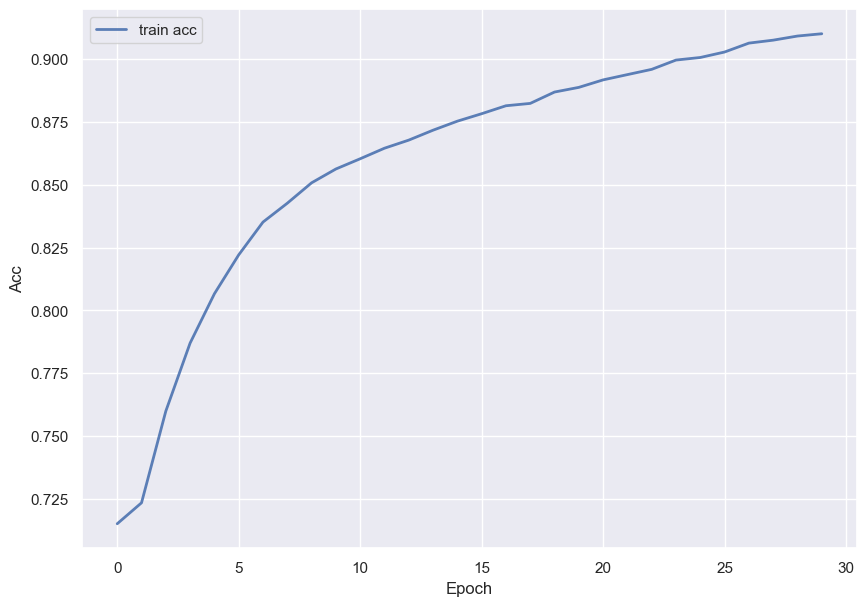

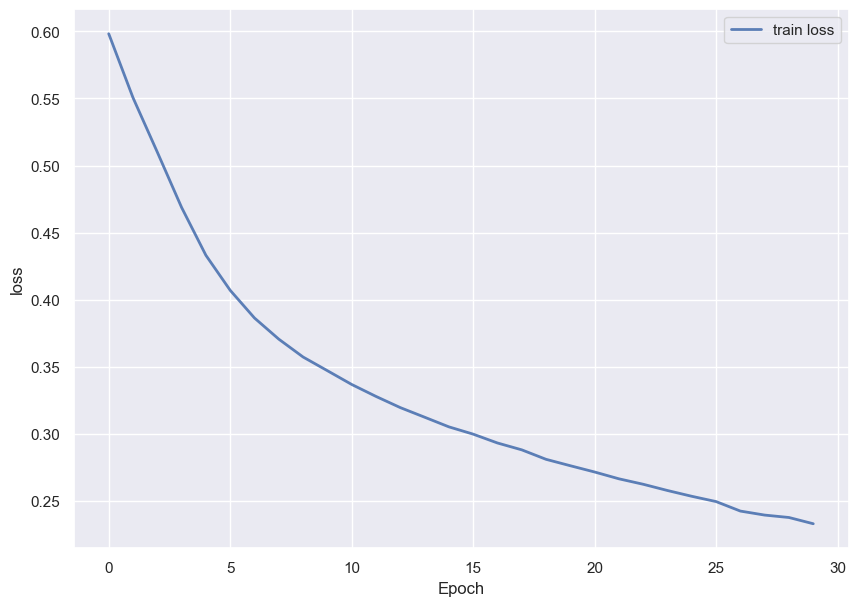

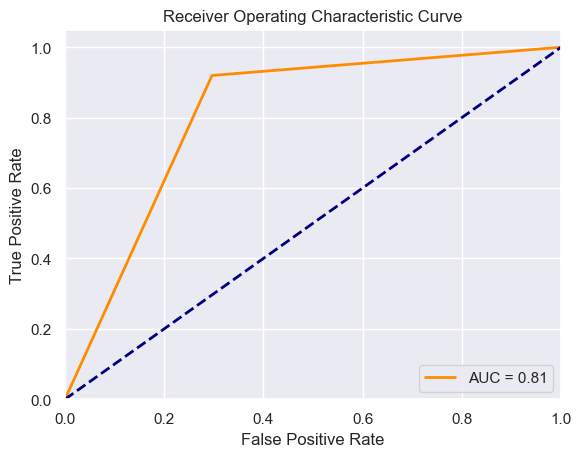

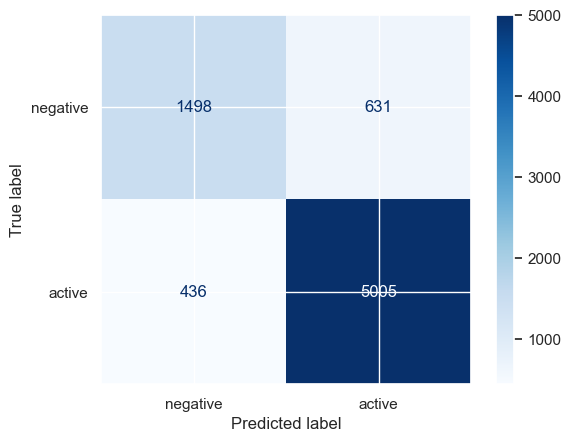

In [16]:
getFormatData() # 数据预处理：数据清洗和词向量
trainer=Trainer()
trainer.train(epochs=30) #数据训练
trainer.test() # 测试

End of epoch 0
Epoch: 0   [===========]  cost: 30.70s;  loss: 224.9283;  train acc: 0.6573;  val acc:0.7301;
End of epoch 1
Epoch: 1   [===========]  cost: 30.82s;  loss: 196.9639;  train acc: 0.7350;  val acc:0.7483;
End of epoch 2
Epoch: 2   [===========]  cost: 30.82s;  loss: 185.9061;  train acc: 0.7566;  val acc:0.7662;
End of epoch 3
Epoch: 3   [===========]  cost: 30.87s;  loss: 173.8868;  train acc: 0.7737;  val acc:0.7844;
End of epoch 4
Epoch: 4   [===========]  cost: 32.30s;  loss: 160.0709;  train acc: 0.7989;  val acc:0.8066;
End of epoch 5
Epoch: 5   [===========]  cost: 33.52s;  loss: 147.2263;  train acc: 0.8202;  val acc:0.8165;
End of epoch 6
Epoch: 6   [===========]  cost: 34.80s;  loss: 138.0797;  train acc: 0.8343;  val acc:0.8310;
End of epoch 7
Epoch: 7   [===========]  cost: 35.10s;  loss: 132.0038;  train acc: 0.8428;  val acc:0.8337;
End of epoch 8
Epoch: 8   [===========]  cost: 34.67s;  loss: 127.1421;  train acc: 0.8504;  val acc:0.8360;
End of epoch 9
Epoc

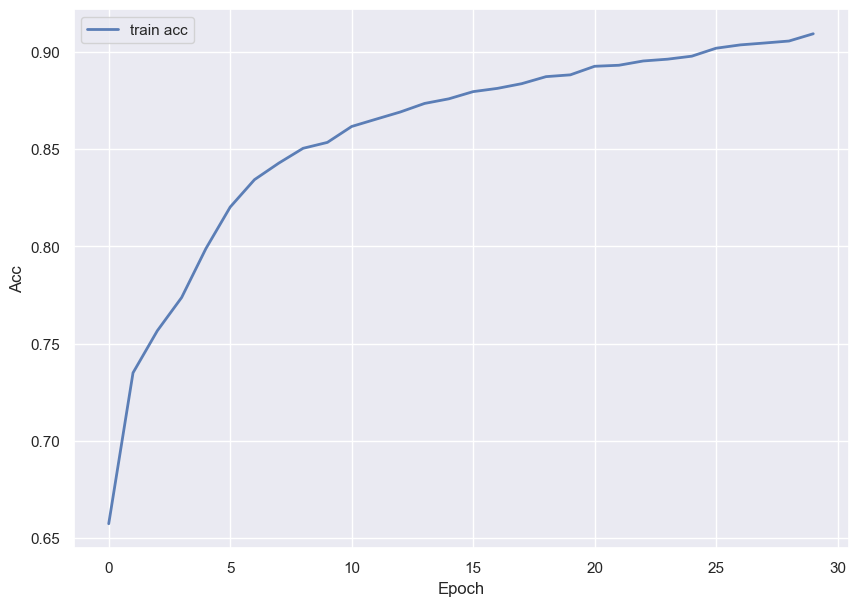

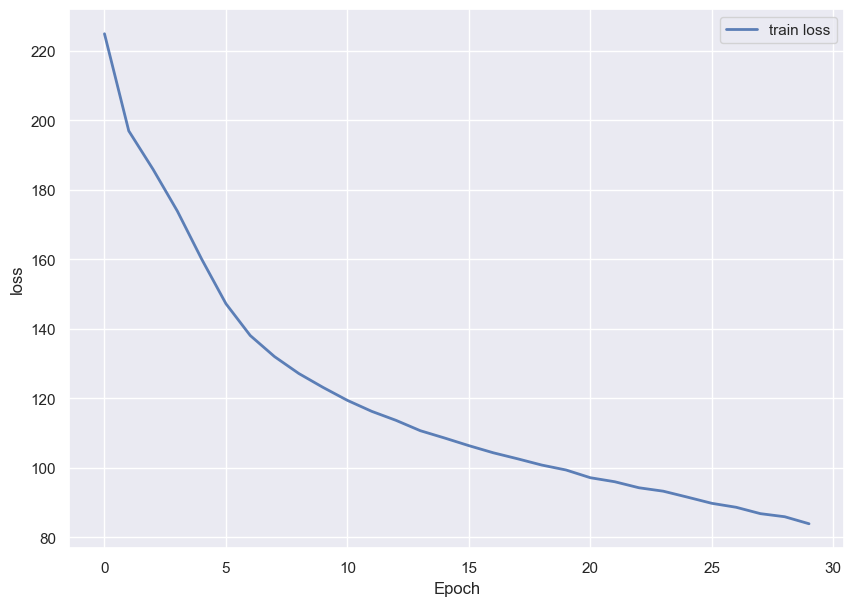

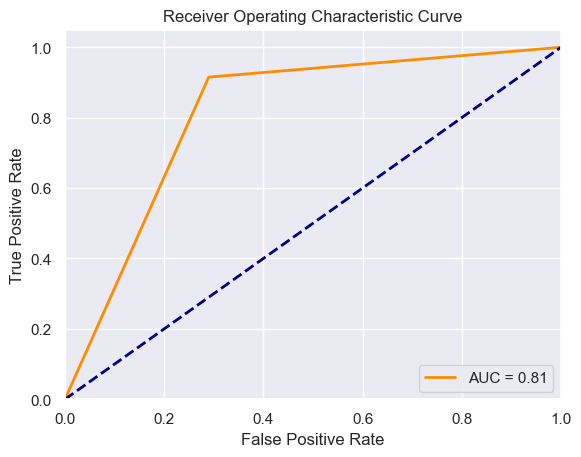

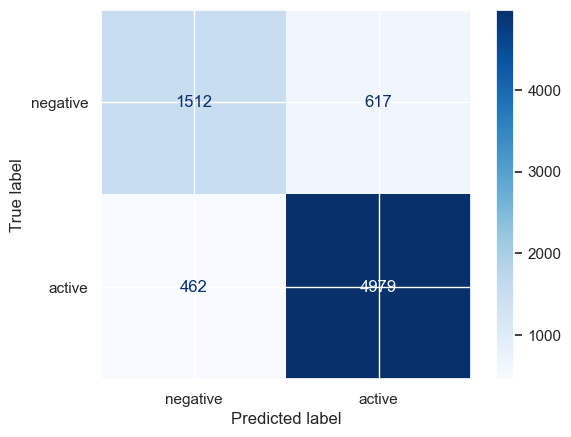

In [59]:
getFormatData() # 数据预处理：数据清洗和词向量
trainer=Trainer()
trainer.train(epochs=30) #数据训练
trainer.test() # 测试

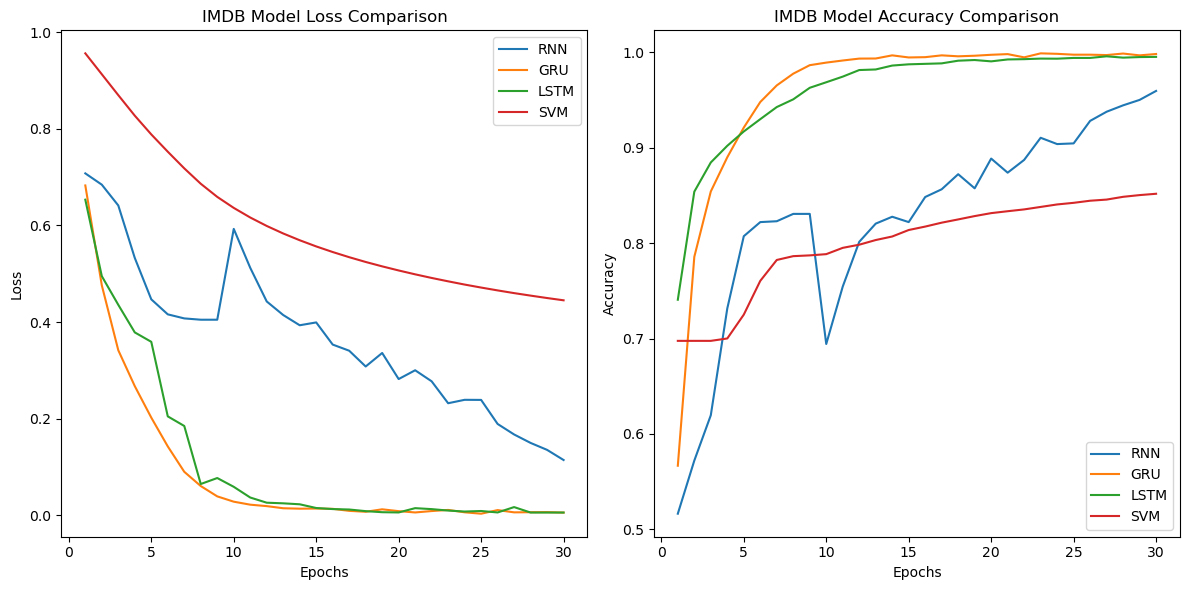

In [3]:
# imdb data
epochs_imdb = range(1, 31)

# Loss plots
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_imdb, [0.7079, 0.6845, 0.6414, 0.5327, 0.4470, 0.4159, 0.4075, 0.4048, 0.4048, 0.5929, 0.5123, 0.4426, 0.4145, 0.3933, 0.3992, 0.3533, 0.3406, 0.3079, 0.3359, 0.2819, 0.3001, 0.2772, 0.2318, 0.2389, 0.2387, 0.1889, 0.1671, 0.1496, 0.1352, 0.1142], label='RNN')
plt.plot(epochs_imdb, [0.6829, 0.4760, 0.3415, 0.2672, 0.2020, 0.1424, 0.0898, 0.0603, 0.0389, 0.0279,0.0217, 0.0187, 0.0143, 0.0134, 0.0137, 0.0131, 0.0089, 0.0070, 0.0121, 0.0083,0.0056, 0.0085, 0.0108, 0.0059, 0.0030, 0.0105, 0.0058, 0.0061, 0.0063, 0.0053], label='GRU')
plt.plot(epochs_imdb, [0.6534, 0.4950, 0.4356, 0.3785, 0.3590, 0.2046, 0.1847, 0.0645, 0.0769, 0.0587, 0.0365, 0.0258, 0.0245, 0.0225, 0.0148, 0.0126, 0.0117, 0.0083, 0.0061, 0.0056, 0.0145, 0.0125, 0.0095, 0.0075, 0.0086, 0.0056, 0.0167, 0.0054, 0.0054, 0.0054], label='LSTM')
plt.plot(epochs_imdb, [0.9565, 0.9132, 0.8699, 0.8274, 0.7886, 0.7528, 0.7183, 0.6864, 0.6592, 0.6364, 0.6165, 0.5990, 0.5834, 0.5694, 0.5566, 0.5450, 0.5343, 0.5244, 0.5153, 0.5068, 0.4988, 0.4913, 0.4843, 0.4776, 0.4714, 0.4655, 0.4599, 0.4547, 0.4497, 0.4450], label='SVM')
plt.title('IMDB Model Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy plots
plt.subplot(1, 2, 2)
plt.plot(epochs_imdb, [0.5164, 0.5721, 0.6196, 0.7316, 0.8073, 0.8221, 0.8230, 0.8307, 0.8307, 0.6943, 0.7545, 0.8014, 0.8205, 0.8277, 0.8221, 0.8484, 0.8565, 0.8723, 0.8575, 0.8887, 0.8739, 0.8873, 0.9105, 0.9039, 0.9046, 0.9282, 0.9378, 0.9445, 0.9502, 0.9596], label='RNN')
plt.plot(epochs_imdb, [0.5667, 0.7857, 0.8542, 0.8901, 0.9212, 0.948, 0.9654, 0.9777, 0.9866, 0.9893, 0.9915, 0.9935, 0.9936, 0.9969, 0.9947, 0.995, 0.9969, 0.9959, 0.9965, 0.9975, 0.9982, 0.9948, 0.999, 0.9985, 0.9976, 0.9976, 0.9972, 0.9988, 0.9969, 0.9983], label='GRU')
plt.plot(epochs_imdb, [0.7407, 0.8540, 0.8846, 0.9021, 0.9171, 0.9300, 0.9427, 0.9508, 0.9629, 0.9687, 0.9746, 0.9815, 0.9821, 0.9862, 0.9875, 0.9880, 0.9885, 0.9913, 0.9920, 0.9906, 0.9926, 0.9929, 0.9935, 0.9934, 0.9942, 0.9942, 0.9959, 0.9945, 0.9951, 0.9953], label='LSTM')
plt.plot(epochs_imdb, [0.6976, 0.6976, 0.6976, 0.7001, 0.7251, 0.7605, 0.7824, 0.7864, 0.7872, 0.7885, 0.7951, 0.7984, 0.8033, 0.8070, 0.8138, 0.8174, 0.8215, 0.8249, 0.8284, 0.8315, 0.8335, 0.8354, 0.8380, 0.8406, 0.8423, 0.8445, 0.8457, 0.8486, 0.8504, 0.8518], label='SVM')
plt.title('IMDB Model Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

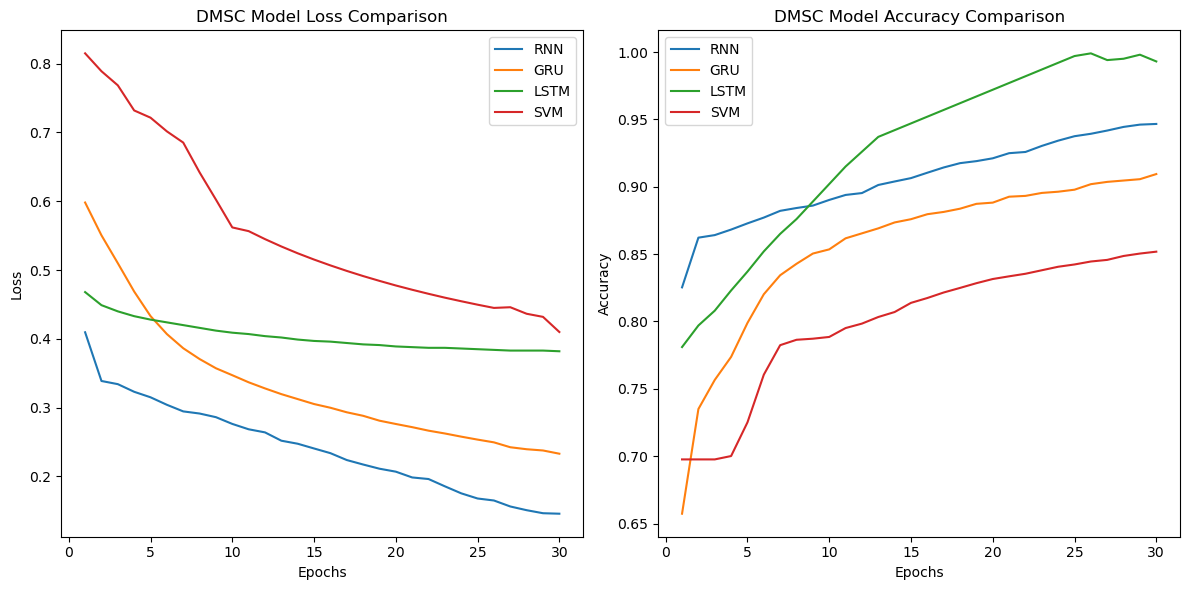

In [9]:
# DMSC data
epochs_dmsc = range(1, 31)

# Loss plot
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_dmsc, [0.4096, 0.3388, 0.3342, 0.3231, 0.3151, 0.3042, 0.2946, 0.2915, 0.2862, 0.2764, 0.2686, 0.2641, 0.2520, 0.2476, 0.2407, 0.2339, 0.2239, 0.2174, 0.2113, 0.2070, 0.1986, 0.1963, 0.1857, 0.1755, 0.1680, 0.1651, 0.1564, 0.1510, 0.1466, 0.1459], label='RNN')
plt.plot(epochs_dmsc, [0.5982, 0.5505, 0.5100, 0.4688, 0.4331, 0.4070, 0.3864, 0.3707, 0.3573, 0.3472,0.3369, 0.3280, 0.3197, 0.3125, 0.3053, 0.2999, 0.2933, 0.2882, 0.2811, 0.2763,0.2717, 0.2666, 0.2625, 0.2579, 0.2536, 0.2496, 0.2425, 0.2396, 0.2378, 0.2331], label='GRU')
plt.plot(epochs_dmsc, [0.468, 0.449, 0.440, 0.433, 0.428, 0.424, 0.420, 0.416, 0.412, 0.409, 0.407, 0.404, 0.402, 0.399, 0.397, 0.396, 0.394, 0.392, 0.391, 0.389, 0.388, 0.387, 0.387, 0.386, 0.385, 0.384, 0.383, 0.383, 0.383, 0.382], label='LSTM')
plt.plot(epochs_dmsc, [0.8150, 0.7890, 0.7685, 0.7320, 0.7215, 0.7016, 0.6853, 0.6420, 0.6024, 0.5620, 0.5566, 0.5450, 0.5343, 0.5244, 0.5153, 0.5068, 0.4988, 0.4913, 0.4843, 0.4776, 0.4714, 0.4655, 0.4599, 0.4547, 0.4497, 0.4450,0.4460,0.4365,0.4320,0.41], label='SVM')
plt.title('DMSC Model Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(epochs_dmsc, [0.8253, 0.8622, 0.8641, 0.8682, 0.8728, 0.8771, 0.8821, 0.8842, 0.8860, 0.8902, 0.8939, 0.8953, 0.9013, 0.9039, 0.9064, 0.9104, 0.9143, 0.9175, 0.9190, 0.9211, 0.9249, 0.9258, 0.9303, 0.9342, 0.9375, 0.9393, 0.9417, 0.9444, 0.9461, 0.9466], label='RNN')
plt.plot(epochs_dmsc, [0.6573, 0.735, 0.7566, 0.7737, 0.7989, 0.8202, 0.8343, 0.8428, 0.8504, 0.8535, 0.8617, 0.8654, 0.8691, 0.8735, 0.8759, 0.8796, 0.8813, 0.8837, 0.8873, 0.8882, 0.8926, 0.8932, 0.8954, 0.8963, 0.8978, 0.9019, 0.9036, 0.9046, 0.9056, 0.9094], label='GRU')
plt.plot(epochs_dmsc, [0.781,0.797,0.808,0.823,0.837,0.852,0.865,0.876,0.889,0.902,0.915,0.926,0.937,0.942,0.947,0.952,0.957,0.962,0.967,0.972,0.977,0.982,0.987,0.992,0.997,0.999,0.994,0.995,0.998,0.993], label='LSTM')
plt.plot(epochs_dmsc, [0.6976, 0.6976, 0.6976, 0.7001, 0.7251, 0.7605, 0.7824, 0.7864, 0.7872, 0.7885, 0.7951, 0.7984, 0.8033, 0.8070, 0.8138, 0.8174, 0.8215, 0.8249, 0.8284, 0.8315, 0.8335, 0.8354, 0.8380, 0.8406, 0.8423, 0.8445, 0.8457, 0.8486, 0.8504, 0.8518], label='SVM')
plt.title('DMSC Model Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

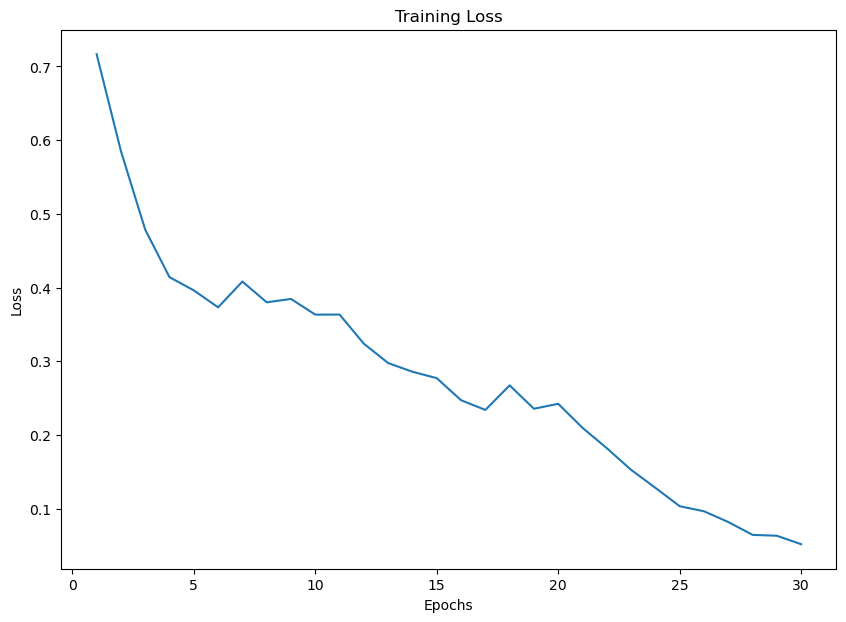

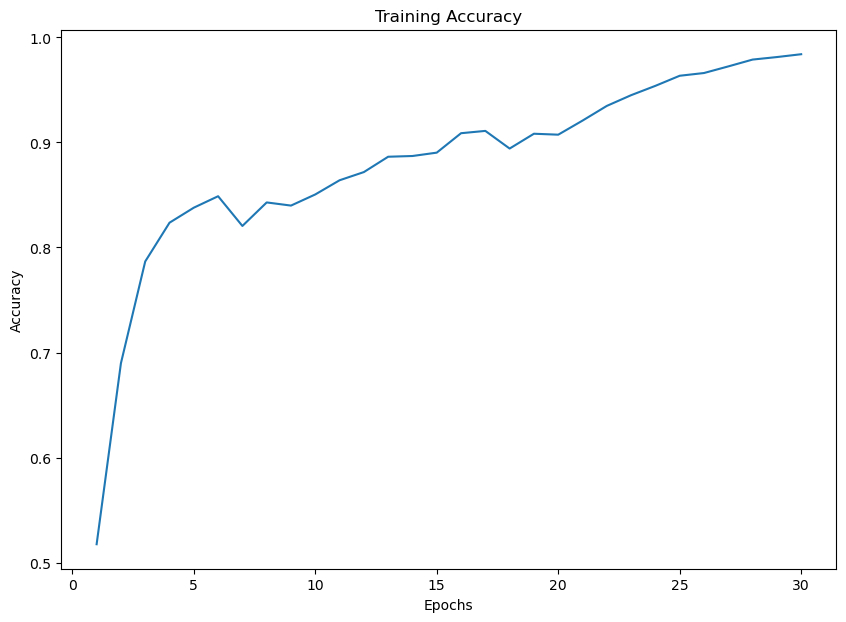

In [6]:
import matplotlib.pyplot as plt

# Data from the provided training logs
epochs = list(range(1, 31))
train_loss = [0.7166, 0.5852, 0.4786, 0.4141, 0.3962, 0.3732, 0.4082, 0.3800, 0.3846, 0.3633,
              0.3634, 0.3238, 0.2976, 0.2858, 0.2771, 0.2472, 0.2340, 0.2673, 0.2356, 0.2423,
              0.2097, 0.1821, 0.1527, 0.1283, 0.1034, 0.0965, 0.0819, 0.0645, 0.0633, 0.0518]

train_accuracy = [0.5175, 0.6898, 0.7867, 0.8236, 0.8379, 0.8488, 0.8205, 0.8429, 0.8399, 0.8505,
                   0.8640, 0.8718, 0.8864, 0.8871, 0.8903, 0.9088, 0.9110, 0.8942, 0.9083, 0.9074,
                   0.9208, 0.9348, 0.9450, 0.9539, 0.9635, 0.9661, 0.9724, 0.9789, 0.9813, 0.9840]

# Plotting the training loss
plt.figure(figsize=(10,7))

plt.plot(epochs, train_loss)
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()
# Plotting the training accuracy
plt.figure(figsize=(10,7))
plt.plot(epochs, train_accuracy)
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()
